In [1]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm



In [2]:
# Transforms

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                                       ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [3]:
# download data
train = datasets.MNIST('./data',train=True,transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform =test_transforms, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

# torch.manual_seed(SEED)

# if cuda:
#   torch.cuda.manual_seed(SEED)

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)



torch.Size([128, 1, 28, 28]) torch.Size([1, 28, 28])
(28, 28)


Text(0.5, 1.0, '6')

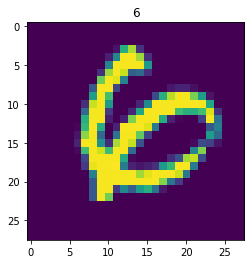

In [5]:
# Visualize Data

dataiter = iter(train_loader)
images,labels = dataiter.next()

print(images.shape, images[0].shape)

print(images[0].numpy().squeeze().shape) # squeeze removes the channel value. 
%matplotlib inline
plt.imshow(images[0].numpy().squeeze())
plt.title(labels[0].item()) #item converts from tensor to value

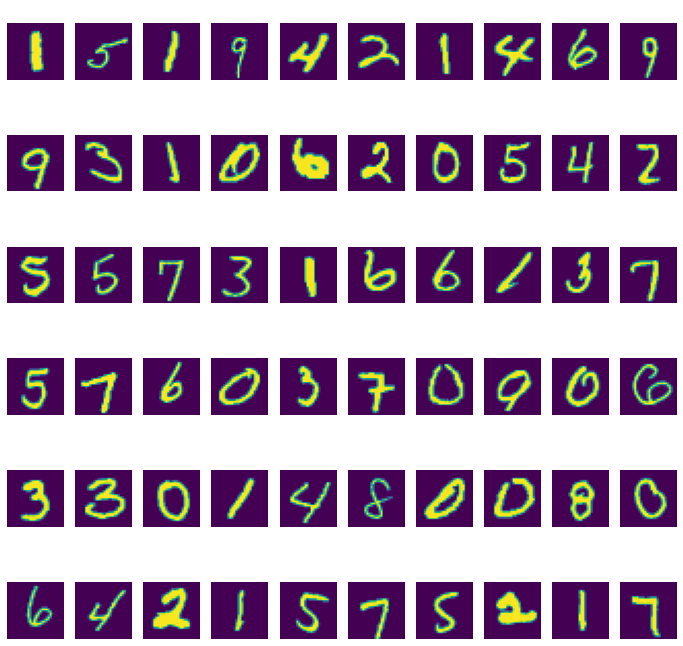

In [6]:
# visualize data in grid format

figure = plt.figure(figsize=(12,12))
num_of_images = 60

for index in range(1, num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze())
  plt.title(labels[index].item(),color='w')

In [7]:
# Model Architecture

dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() ,
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5

    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

# MODULAR

In [8]:
# Modular PRogramming

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm


class Trainer():
  '''Trainer Classe '''
  
  def __init__(self,model,device,train_loader,test_loader,optimizer,epoch,schedul):
    self.model = model
    self.device= device
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.optimizer = optimizer
    self.epoch = epoch
    self.scheduler = schedul


  def train(self,l1_lambda=0, l2_lambda=0):

    self.l1_lambda = l1_lambda
    self.l2_lambda = l2_lambda

    comb_train_losses = []
    comb_train_acc    = []
    comb_test_losses  = []
    comb_test_acc     = []
    # EPOCHS = 10
    for epoch in range(self.epoch):
        
        print("EPOCH:", epoch)
        print('learning rate ', self.scheduler.get_lr())

        # trainer = Trainer(model,device,train_loader,test_loader,optimizer,epoch)

        train_ac, train_los = trainer.train_mod()
        scheduler.step()    
        test_ac, test_los = trainer.test_mod()

        comb_train_losses.extend(train_los)
        comb_train_acc.extend(train_ac)
        comb_test_losses.extend(test_los)
        comb_test_acc.extend(test_ac)
    return ((comb_train_acc,comb_train_losses),(comb_test_acc,comb_test_losses)) 

  def train_mod(self):

    train_losses = []
    train_acc = []
    
    self.model.train()
    pbar = tqdm(self.train_loader)

    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(self.device), target.to(self.device)

      # Init
      self.optimizer.zero_grad()

      # Predict
      y_pred = self.model(data)

      # Calculate loss

      criterion = F.nll_loss(y_pred, target)

      if self.l1_lambda > 0:
          # l1 regularization
          l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

          loss = criterion + self.l2_lambda * l1_reg_loss
      else:
          loss = criterion

      # loss = criterion
      
      train_losses.append(loss)

      # Backpropagation
      loss.backward()
      self.optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)
    return (train_acc,train_losses)



  def test_mod(self):
    test_losses = []
    test_acc = []
    self.model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in self.test_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return (test_acc,test_losses)


    

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# plt.style.use("dark_background")

def plot_metrics(train_metric,test_metric):
  (train_acc, train_losses) = train_metric
  (test_acc, test_losses) = test_metric


  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss",color='r')
  axs[1, 0].plot(train_acc[500:])
  axs[1, 0].set_title("Training Accuracy",color='r')
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss",color='r')
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy", color='r')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

metric_values = {}
models={}



## No Regularizaiton

In [11]:
exp_name = 'no-l1 & l2'

EPOCHS = 5

trainer = Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.09784331172704697 Batch_id=468 Accuracy=87.26: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0888, Accuracy: 9745/10000 (97.45%)

EPOCH: 1
learning rate  [0.01]


Loss=0.08330908417701721 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9856/10000 (98.56%)

EPOCH: 2
learning rate  [0.01]


Loss=0.10211915522813797 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9887/10000 (98.87%)

EPOCH: 3
learning rate  [0.01]


Loss=0.09637194126844406 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9919/10000 (99.19%)

EPOCH: 4
learning rate  [0.01]


Loss=0.03928220644593239 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]



Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)



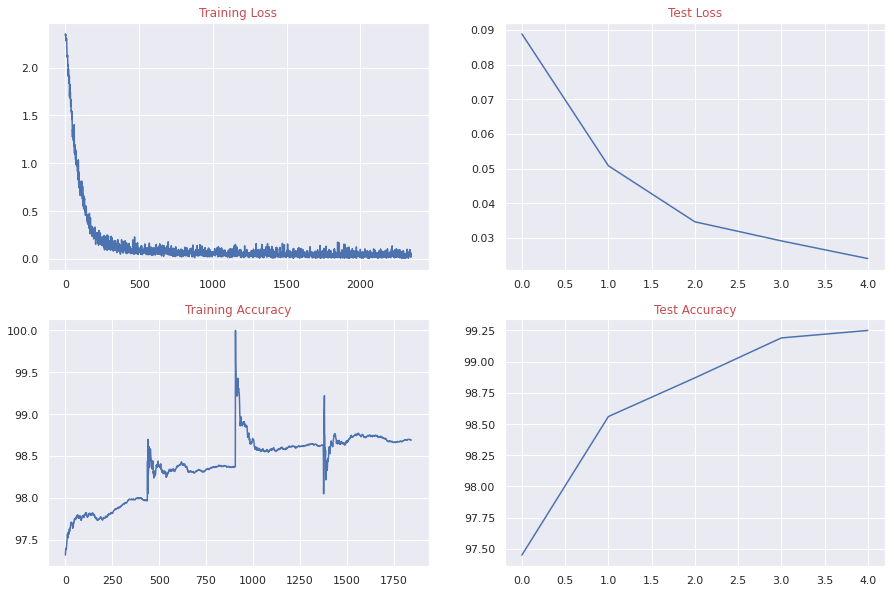

In [12]:
plot_metrics(train_metric, test_metric)

## L1 Regularization

In [13]:
EPOCHS = 5
exp_name = 'Only l1'

trainer = Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
train_metric, test_metric = trainer.train(l1_lambda=5e-4, l2_lambda=0)

# save the metrics in dictionary

metric_values[exp_name] = (train_metric, test_metric)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.07476808875799179 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

EPOCH: 1
learning rate  [2.5e-05]


Loss=0.022219203412532806 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 2
learning rate  [0.0005]


Loss=0.009909589774906635 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 3
learning rate  [0.0005]


Loss=0.0198573749512434 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 4
learning rate  [0.0005]


Loss=0.025928126648068428 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]



Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)



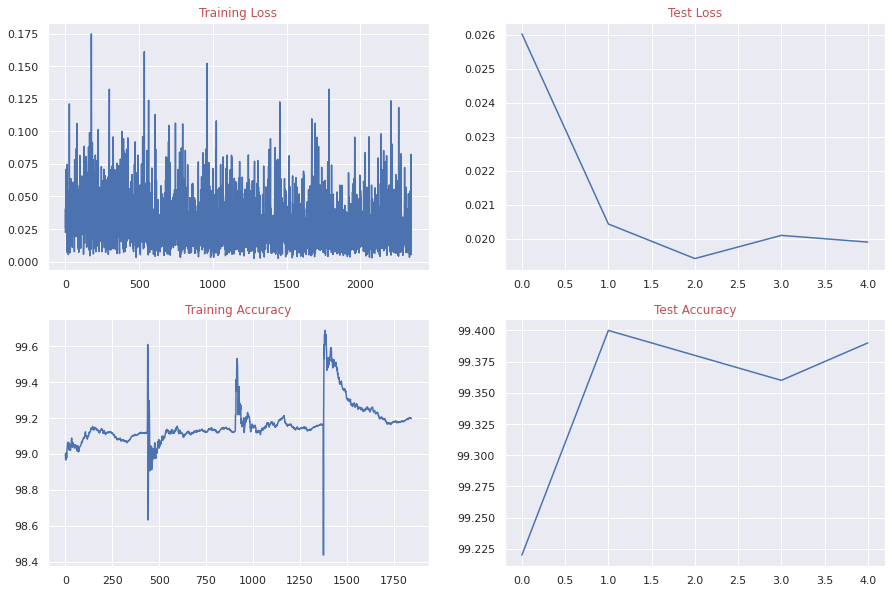

In [14]:
plot_metrics(train_metric, test_metric)

In [15]:
metric_values.keys()

dict_keys(['no-l1 & l2', 'Only l1'])

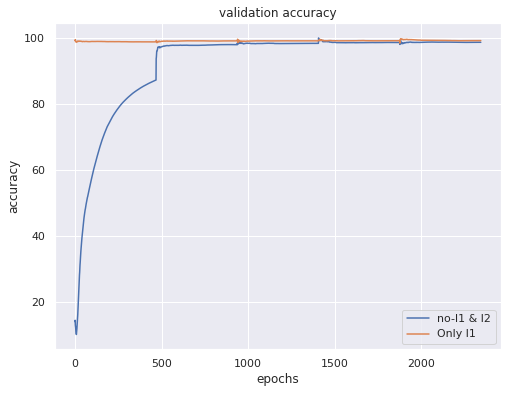

In [18]:
plt.figure(figsize=(8,6))
plt.title('validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
for idx,exp_name in enumerate(metric_values.keys()):
  train_metric,test_metric = metric_values[exp_name]
  train_acc,train_loss = train_metric
  test_acc,test_loss = test_metric
  plt.plot(train_acc,label='{}'.format(exp_name))
plt.legend()
plt.show()

In [17]:
# # Visualize the misclassified images
# model.eval()

# figure = plt.figure(figsize=(10,10))
# num_of_images = 25
# index=1


# with torch.no_grad():
#   for data,target in test_loader:
#     data,target = data.to(device), target.to(device)
#     output = model(data)
#     pred = output.argmax(dim=1,keepdim=True)
#     act = target.view_as(pred)
#     bool_vec = ~pred.eq(act) # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa

#     # now extract the index number from the tensor which has 'true' 
#     idx = list(np.where(bool_vec.cpu().numpy())[0])

#     if idx: # if not a blank list
#       idx_list = idx
#       # print(data[idx_list[0]].shape)
#       if index < num_of_images+1:
            
#           plt.subplot(5,5,index)
#           plt.axis('off')
#           titl = 'act/pred : ' + str(target[idx[0]].cpu().item()) + '/' + str(pred[idx[0]].cpu().item())
#           plt.imshow(data[idx[0]].cpu().numpy().squeeze()) # prints the 1st index of each batch. 
#           plt.title(titl)
#           index+=1
